In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import kaggle
import zipfile
from glob import glob

In [ ]:
!kaggle datasets download -d bme3412/iphone-on-ebay-webscrape-daily-20212022

In [ ]:
zipname = 'iphone-on-ebay-webscrape-daily-20212022.zip'
target_directory = 'C:/Users/loren/Desktop/dap/dap/DailyData'
with zipfile.ZipFile(zipname, 'r') as file:
    file.extractall(path=target_directory)

In [ ]:
csvs = glob("DailyData/*.csv")
data = [pd.read_csv(file) for file in csvs]
rawdata = pd.concat(data, ignore_index=True)
rawdata['Date'] = pd.to_datetime(rawdata['Date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')

In [ ]:
rawdata['Model'] = rawdata['Product'].str.extract(r'Apple iPhone\s?([^\s/-]+)', expand=False, flags=re.IGNORECASE)
rawdata = rawdata.dropna(subset=['Model'])

rawdata['Storage'] = rawdata['Product'].str.extract(r'(\d+GB)', expand=False)
rawdata = rawdata.dropna(subset=['Storage'])
rawdata['Storage'] = rawdata['Storage'].str.rstrip('GB').astype(int)

In [ ]:
rawdata = rawdata.rename(columns={'Unnamed: 0': 'Vendor ID'})

In [ ]:
rawdata['Price'] = rawdata['Price'].replace('[\\$,]', '', regex=True)

def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return np.nan

rawdata['Price'] = rawdata['Price'].apply(lambda x: np.mean([convert_to_float(i) for i in x.split(' to ')] if ' to ' in x else convert_to_float(x) if x else np.nan))

In [ ]:
model_mapping = {
    'Thirteen': '13',
    'Xr': 'XR',
    'Xs': 'XS',
    '4s': '4S',
    '5s,': '5S',
    '12,': '12',
    '5s': '5S',
    '5c': '5C',
    '8,': '8',
    '6s': '6S',
    '6s,': '6S',
    '7,': '7',
    's': '8'
}

rawdata['Model'] = rawdata['Model'].replace(model_mapping)

In [ ]:
print(rawdata.groupby('Vendor ID')['Product'].nunique())

In [ ]:
print(rawdata.groupby('Model')['Price'].mean().sort_values())

In [ ]:
print(rawdata['Model'].unique())

In [ ]:
# Convert the 'Date' column to datetime format
rawdata['Date'] = pd.to_datetime(rawdata['Date'], format='%Y-%m-%d')

# Calculate the duration for each listing
rawdata['Duration'] = rawdata.groupby('Vendor ID')['Date'].transform(lambda x: (x.max() - x.min()).days)

# Create a new column for the year
rawdata['Year'] = rawdata['Date'].dt.year

# Define smaller price ranges with steps of 50
price_ranges = [(0, 50), (50, 100), (100, 150), (150, 200), (200, 250), (250, 300), (300, 350), (350, 400), (400, 450), (450, 500), (500, 550), (550, 600), (600, 650), (650, 700), (700, 750), (750, 800), (800, 850), (850, 900), (900, 950), (950, 1000), (1000, float('inf'))]

# Create a new column for price range
rawdata['Price Range'] = pd.cut(rawdata['Price'], bins=[x[0] for x in price_ranges] + [float('inf')], labels=[f"{x[0]}-{x[1]}" for x in price_ranges])

# Group by phone model, year, and price range, and calculate the mean duration
result = rawdata.groupby(['Model', 'Year', 'Price Range'])['Duration'].mean()

# Display the result
print(result)


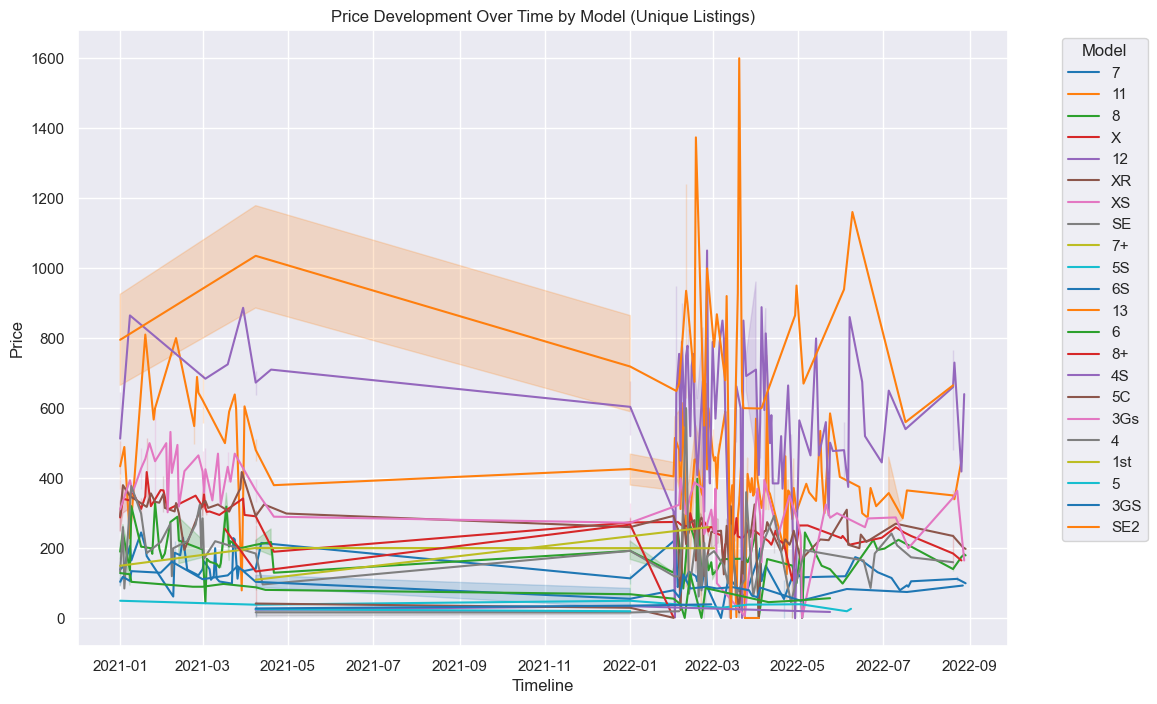

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="darkgrid")

# Drop duplicate rows based on Vendor ID and Product
unique_listings = rawdata.drop_duplicates(subset=['Product'])

# Create a line plot for each model
plt.figure(figsize=(12, 8))
sns.lineplot(x='Date', y='Price', hue='Model', data=unique_listings, palette='tab10')

# Set plot labels and title
plt.xlabel('Timeline')
plt.ylabel('Price')
plt.title('Price Development Over Time by Model (Unique Listings)')

# Show the legend
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()
